<a href="https://colab.research.google.com/github/QueueDoubleU/MLFinalProject/blob/main/SCOTUS_Argument_Analysis_Mode__Workingl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 """
 NOTE: For TPU only
 Must go to Command Pallette (Cmd/Ctrl+Shift+P) and enter "Use Fallback Runtime" to enable running older python
 """
 #! pip install cloud-tpu-client==0.10.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

'\nNOTE: For TPU only\nMust go to Command Pallette (Cmd/Ctrl+Shift+P) and enter "Use Fallback Runtime" to enable running older python\n'

After expanding the sequence length, we quickly overran the available GPU RAM. Below, we import tools for utilizing mixed precision training to easily conserve memory. We also implemented gradient accumulation for the same purpose.

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install transformers

In [ ]:
!pip install category_encoders

In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gco = gspread.authorize(creds)

Mounted at /content/drive


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:

import pandas as pd
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn
import category_encoders as ce
import transformers

from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, BertTokenizerFast, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
#check is gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('gpu available')
else:
    device = torch.device('cpu')
    print('gpu not available')

gpu available


Our first attempt involved creating full transcripts for each case and exporting them as CSVs, which we then loaded into the script as needed. This exceeded the memory limits of Google Colab's TPUs and GPUs during training.

We then tried a similar process but with the the "utterance" transcripts -- essentially lengths of text spoken by one person. Here, however, the RAM limit was exceeded when using the package that creates the utterance objects. We do not know why the RAM was exceeded here given that we were able to run the package locally on machines with lower amounts of RAM.

Our third attempt was to create a dataframe of all utterances and the associated text and export it as a csv, roughly 1.7 million lines and 0.6GB as opposed to the packages ~7.3GB.

In [ ]:
# set to run with utterances or conversations
utts = True

# Set flag for what percentage of the data we want to analyze
n = 0.02

In [ ]:
# create dataframe of utterances by case
df_utts = pd.read_csv('/content/drive/MyDrive/INFO251Final/Utterances_DataFrame.csv')

# # create dataframe by conversation record
df_convo = pd.read_csv('/content/drive/MyDrive/INFO251Final/Outcomes_NoTranscript.csv')

# # create datafrae of Martin Quinn scores to merge with dataframes
martin_quinn = gco.open('MartinQuinnScores')

if not utts:
  df_args = pd.read_csv('/content/drive/MyDrive/INFO251Final/ArgumentsTable.csv')

<ipython-input-10-ce75f8aa6615>:2: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_utts = pd.read_csv('/content/drive/MyDrive/INFO251Final/Utterances_DataFrame.csv')


In [ ]:
df_utt = df_utts.copy()

In [ ]:
# some of the martin-quinn scores in df_utt are strings
# corrected here
df_utt.loc[df_utt['mq_score'] == '0.162.5', 'mq_score'] = 0.163
df_utt.loc[df_utt['mq_score'] == '0.559', 'mq_score'] = 0.559
df_utt.loc[df_utt['mq_score'] == '0.58', 'mq_score'] = 0.58

In [ ]:
df_utt.mq_score.unique()

array([0.559, 0.163, 0.58, 0.643, 0.335, 0.443, -0.041, -1.079, -1.133,
       -0.707, -0.56, -0.414, -1.043, -0.896, 0.19, 0.381, 0.64, 0.945,
       0.609, 0.615, 0.492, 0.473, 0.233, 0.156, 0.24, 0.231, 0.266,
       0.673, 0.877, 0.828, 0.932, 0.878, 0.972, 1.098, 0.876, 0.919,
       0.756, 0.838, 0.817, 0.736, 0.685, 0.782, 0.798, 0.861, 0.849,
       0.589, 0.371, 0.26, 0.222, 0.11, 0.2705, 0.458, 0.411, 0.576,
       0.516, 0.577, 0.296, 0.068, -0.227, -0.269, -0.059, 0.298, 0.402,
       0.355], dtype=object)

In [ ]:
df_convo.win_side.isnull().values.sum()

13

In [ ]:
df_utt.shape, df_convo.shape

((1700789, 17), (7817, 10))

In [ ]:
def clean_utts(df_utt):
    # updating columns

    # rename columns
    df_utt = df_utt.rename(columns={'meta.votes_side': 'votes_side',
                                      'meta.case_id': 'case_id',
                                      'med': 'mq_score',
                                      'conversation_id': 'convo_id',
                                      'term_year': 'term',
                                      'text': 'words'})
    # set term type to integer
    df_utt.term = df_utt.term.astype('int64')

    # add "win_side" to utterance dataframe
    df_utt['win_side'] = df_utt.merge(df_convo, on='case_id', how='left')['win_side']

    # Remove instances where case outcome was unknown or ????
    df_utt.drop(df_utt[df_utt['win_side'] == -1.0].index, inplace = True)
    df_utt.drop(df_utt[df_utt['win_side'] == 2.0].index, inplace = True)

    # drop unused columns
    # NOTE we may want to try an analysis on some of these later on
    df_utt = df_utt.drop(columns=['timestamp',
                                  'meta.start_times',
                                  'meta.stop_times',
                                  'meta.timestamp',
                                  'vectors',
                                  'Unnamed: 0',
                                  'meta.side'])

    df_utt = df_utt.rename(columns={'text': 'words', 'meta.speaker_type':'speaker_type'})

    # Remove null values from the few cases with incomplete data
    df_utt = df_utt.dropna(subset=['win_side'])

    # convert win_side values to integers for later processings
    df_utt.win_side = df_utt.win_side.astype('int64')


    return df_utt

In [ ]:
df_utt.head()

,Unnamed: 0,timestamp,text,speaker,reply_to,convo_id,case_id,meta.start_times,meta.stop_times,meta.speaker_type,meta.side,meta.timestamp,vectors,utt_id,term,docket_id,mq_score
0,0,NaN,"Number 71, Lonnie Affronti versus United State...",j__earl_warren,NaN,13127,1955_71,"[0.0, 7.624]","[7.624, 9.218]",J,NaN,0.000,[],13127__0_000,1955,71,0.559
1,1,NaN,May it please the Court.\nWe are here by writ ...,harry_f_murphy,13127__0_000,13127,1955_71,"[9.218, 11.538, 15.653, 22.722, 28.849, 33.575]","[11.538, 15.653, 22.722, 28.849, 33.575, 48.138]",A,1.0,9.218,[],13127__0_001,1955,71,0.559
2,2,NaN,Consecutive sentences.,j__william_o_douglas,13127__0_001,13127,1955_71,[48.138],[49.315],J,NaN,48.138,[],13127__0_002,1955,71,0.559
3,3,NaN,"Consecutive sentences.\nIn this case, the defe...",harry_f_murphy,13127__0_002,13127,1955_71,"[49.315, 51.844, 60.81, 67.083, 72.584, 89.839...","[51.844, 60.81, 67.083, 72.584, 89.839, 95.873...",A,1.0,49.315,[],13127__0_003,1955,71,0.559
4,4,NaN,Was the aggregate prison sentence was 20 or 25...,<INAUDIBLE>,13127__0_003,13127,1955_71,[174.058],[176.766],NaN,NaN,174.058,[],13127__0_004,1955,71,0.559


In [ ]:
def clean_convos(df_convo):
  # Remove instances where case outcome was unknown or ????
  df_convo.drop(df_convo[df_convo['win_side'] == -1.0].index, inplace = True)
  df_convo.drop(df_convo[df_convo['win_side'] == 2.0].index, inplace = True)

  # convert term from object to int
  df_convo.term = df_convo.term.astype('int64')

  # drop unused columns
  # NOTE we may want to try an analysis on some of these later on. Save memory now
  df_convo = df_convo.drop(columns=['Unnamed: 0', 'vectors'])

  # 3 cases have null data due to oddities of transcribing data pre-digital transcripts
  df_convo = df_convo.dropna()

  return df_convo

In [ ]:
# Set flag for running by conversation or utterances
if utts:
  df_utt = clean_utts(df_utt)


In [ ]:
df_utt.iloc[-35:-30,:]

,words,speaker,reply_to,convo_id,case_id,speaker_type,utt_id,term,docket_id,mq_score,win_side
1700754,Would we have to get that passed by the Senate...,j__john_g_roberts_jr,24969__1_077,24969,2019_19-67,J,24969__1_078,2019,19-67,0.355,0
1700755,-- and then signed by the President before we ...,j__john_g_roberts_jr,24969__1_078,24969,2019_19-67,J,24969__1_079,2019,19-67,0.355,0
1700756,"Absolutely, Mr. Chief Justice.\nAnd the fact t...",mark_c_fleming,24969__1_079,24969,2019_19-67,A,24969__1_080,2019,19-67,0.355,0
1700757,Would you talk a little bit about that general...,j__elena_kagan,24969__1_080,24969,2019_19-67,J,24969__1_081,2019,19-67,0.355,0
1700758,I -- I don't think it's possible in this case ...,mark_c_fleming,24969__1_081,24969,2019_19-67,A,24969__1_082,2019,19-67,0.355,0


In [ ]:
# create embeddings for case_id across full dataset
# we want the model to understand utterance grouping without
# using case_ids as a predictive feature directly
# We can do this only because we later prevent data leakage below
# by using a grouped trained test split

case_encoder = ce.OrdinalEncoder(handle_unknown='value', handle_missing='value')
df_utt['case_encoded'] = case_encoder.fit_transform(df_utt['case_id'])

In [ ]:
# define the number of unique features for each categorical feature
# this is for later use when defining our model architecture such that
# we can concatenate encoded featuers

num_cases = int(df_utt.case_encoded.nunique() + 1) # number of unique case_ids
num_speakers = int(df_utt.speaker.nunique() + 2) # number of unique speakers (+1 for NaNs)
num_speaker_types = int(df_utt.speaker_type.nunique() + 2) # number of unique speaker types (+1 for NaNs)


In [ ]:
df_convo = clean_convos(df_convo)

In [ ]:
# Assert n is a percent
assert(n <= 1)

if n > 0.2:
  print("WARNING: HIGH COMPUTATION SCENARIO")

In [ ]:
# Take a sample of df_convos or df_utts to test on. Utterances are sampled from most recent
if utts:
  n = int(np.round(n*len(df_utt)))
  df_test = df_utt.sort_values(by=['term']).iloc[-n:]

else:
  df_test = df_convo.sample(n=7000, replace=False, random_state=12)

In [ ]:
df_test.speaker_type.value_counts()

J    17846
A    16068
Name: speaker_type, dtype: int64

In [ ]:
##### Delete for now

if not utts:
  del(df_utt)

In [ ]:
len(df_utt)

1697746

In [ ]:
# create a helper function that gets a random contiguous chunk of words from a transcript
# this is used for convo analysis given shorter length of utterances

random.seed(123)

def get_random_chunk(text, n_mean=2500, n_stddev=75):
    words = text.split()

    n = int(np.random.normal(n_mean, n_stddev))
    n = max(1, min(n, len(words))) # Ensure n is between 1 and the number of words in the text

    if len(words) <= n:
        return text

    start = random.randint(0, len(words) - n)
    end = start + n
    return " ".join(words[start:end])

In [ ]:
# pull transcripts for each utterance or conversation and store in "words" column
# This method separately creates the transcripts for each conversation and stores them in a
# separate folder for reference. Although this allowed for easy grouping by case, it
# overwhelmed memory allocations

def add_transcripts(df_test, utts=False):
  for index, row in df_test.iterrows():


    if utts:
      folder_path = '/content/drive/MyDrive/INFO251Final/Trancripts_uttid_caseid/'
      read_path = folder_path+str(row['utt_id'])+'_'+str(row['case_id'])+'.txt'

      transcript = open(read_path, 'r')
      text = transcript.read()

      text = get_random_chunk(text)

      df_test.loc[index, 'words'] = text

      transcript.close()

    else:
      folder_path = '/content/drive/MyDrive/INFO251Final/Trancripts_Case_Convo/'
      read_path = folder_path+str(row['convo_id'])+'_'+str(row['case_id'])+'.txt'

      transcript = open(read_path, 'r')
      text = transcript.read()

      text = get_random_chunk(text)

      df_test.at[index, 'words'] = text

      transcript.close()

  return df_test


In [ ]:
# df_test = add_transcripts(df_test)
print(f"df_utt cases overturned: {df_utt.win_side.sum()}")
print(f"df_test cases overturned: {df_test.win_side.sum()}")
print(f"shape of df_utt: {df_utt.shape}")
print(f"shape of df_test: {df_test.shape}")

df_utt cases overturned: 1074307
df_test cases overturned: 19307
shape of df_utt: (1697746, 12)
shape of df_test: (33955, 12)


In [ ]:
if not utts:
  df_args = df_args.rename(columns={'meta.case_id': 'case_id', 'case_transcript': 'words'})

  # df_test = df_test.merge(df_args[['convo_id', 'words']], on='convo_id')

  df_test = df_convo.merge(df_args, on='convo_id', how='left')['words']

else:
  df_test = df_test


In [ ]:
df_test.head()

,words,speaker,reply_to,convo_id,case_id,speaker_type,utt_id,term,docket_id,mq_score,win_side,case_encoded
1661303,"Thank you, Mr. Chief Justice, and may it pleas...",david_l_franklin,24539__1_067,24539,2017_16-1466,A,24539__2_000,2017,16-1466,0.298,0,6566
1661304,Garcetti involved government speech.\nWhat we'...,j__anthony_m_kennedy,24539__2_000,24539,2017_16-1466,J,24539__2_001,2017,16-1466,0.298,0,6566
1661305,"I'm happy to speak to that, Justice Kennedy.\n...",david_l_franklin,24539__2_001,24539,2017_16-1466,A,24539__2_002,2017,16-1466,0.298,0,6566
1661306,Suppose that -- suppose that 80 percent of the...,j__anthony_m_kennedy,24539__2_002,24539,2017_16-1466,J,24539__2_003,2017,16-1466,0.298,0,6566
1661307,"I -- I don't know that it would, Your Honor.\n...",david_l_franklin,24539__2_003,24539,2017_16-1466,A,24539__2_004,2017,16-1466,0.298,0,6566


In [ ]:
# convert to int for later reference by language models
df_test['win_side'] = df_test['win_side'].astype(int)

In [ ]:
df_test.win_side.value_counts()

1    19307
0    14648
Name: win_side, dtype: int64

In [ ]:
import gc
gc.collect()

53

In [ ]:
df_test.head()

,words,speaker,reply_to,convo_id,case_id,speaker_type,utt_id,term,docket_id,mq_score,win_side,case_encoded
1661303,"Thank you, Mr. Chief Justice, and may it pleas...",david_l_franklin,24539__1_067,24539,2017_16-1466,A,24539__2_000,2017,16-1466,0.298,0,6566
1661304,Garcetti involved government speech.\nWhat we'...,j__anthony_m_kennedy,24539__2_000,24539,2017_16-1466,J,24539__2_001,2017,16-1466,0.298,0,6566
1661305,"I'm happy to speak to that, Justice Kennedy.\n...",david_l_franklin,24539__2_001,24539,2017_16-1466,A,24539__2_002,2017,16-1466,0.298,0,6566
1661306,Suppose that -- suppose that 80 percent of the...,j__anthony_m_kennedy,24539__2_002,24539,2017_16-1466,J,24539__2_003,2017,16-1466,0.298,0,6566
1661307,"I -- I don't know that it would, Your Honor.\n...",david_l_franklin,24539__2_003,24539,2017_16-1466,A,24539__2_004,2017,16-1466,0.298,0,6566


In [ ]:
#### IF USING UTTERANCES
# Each utterance needs to come from the same case to ensure correct argument analysis. Use group split
# Run train test split with conversation grouping

if utts:
  gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=123)

  groups = df_test['case_id']
  X = df_test.drop(columns = ['win_side'])
  y = df_test['win_side']

  # Get the indices for training and intermediary sets
  train_idx, temp_idx = next(gss.split(X, y, groups))

  # create train and intermediary sets
  train_feat, temp_feat, train_labels, temp_labels = X.iloc[train_idx], X.iloc[temp_idx], y.iloc[train_idx], y.iloc[temp_idx]

  # Also subset groups data for correct indexing
  groups_train, groups_temp = groups.iloc[train_idx], groups.iloc[temp_idx]

  # second split from intermediary for test and validation
  gss_val = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=123)

  # Get the indices from intermediary for test and validation sets
  test_idx, val_idx = next(gss.split(temp_feat, temp_labels, groups_temp))

  # create test and validation sets
  val_feat, test_feat, val_labels, test_labels = temp_feat.iloc[test_idx], \
                                                temp_feat.iloc[val_idx], \
                                                temp_labels.iloc[test_idx], \
                                                temp_labels.iloc[val_idx]

else:
  # split dataset into train, validation and test sets
  train_feat, temp_feat, train_labels, temp_labels = train_test_split(df_test.drop(columns=['win_side']),
                                                                    df_test['win_side'],
                                                                    random_state=123,
                                                                    test_size=0.3)


  val_feat, test_feat, val_labels, test_labels = train_test_split(temp_feat,
                                                                temp_labels,
                                                                random_state=123,
                                                                test_size=0.5)


In [ ]:
train_feat.head()

,words,speaker,reply_to,convo_id,case_id,speaker_type,utt_id,term,docket_id,mq_score,case_encoded
1661160,"I'm sorry, they don't get -- people don't get ...",j__sonia_sotomayor,24581__3_000,24581,2017_16-980,J,24581__3_001,2017,16-980,0.298,6565
1661161,"Under the NVRA, you're only -- the minimum req...",eric_e_murphy,24581__3_001,24581,2017_16-980,A,24581__3_002,2017,16-980,0.298,6565
1661162,I'm not asking --,j__sonia_sotomayor,24581__3_002,24581,2017_16-980,J,24581__3_003,2017,16-980,0.298,6565
1661163,Yeah.,eric_e_murphy,24581__3_003,24581,2017_16-980,A,24581__3_004,2017,16-980,0.298,6565
1661164,"Under Ohio's law, do they get only one notice?",j__sonia_sotomayor,24581__3_004,24581,2017_16-980,J,24581__3_005,2017,16-980,0.298,6565


In [ ]:
# delete older dfs to free up memory
del(martin_quinn)

In [ ]:
gc.collect()

0

In [ ]:
########################
# BigBird Model
# Load the BigBird model
# bigbird = BigBirdModel.from_pretrained('google/bigbird-roberta-base')

# Load the BigBird tokenizer
# tokenizer = BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base')
#########################


#########################
# BERT base model
# import BERT-base pretrained model
#bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
#########################


#########################
# INSERT DeBERTa
#########################


#########################
# Load the Legal-BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

# Load the Legal-BERT model
Legal_bert = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased",
                                       num_labels=2)
model_name = 'legal_bert'
#########################



<Axes: >

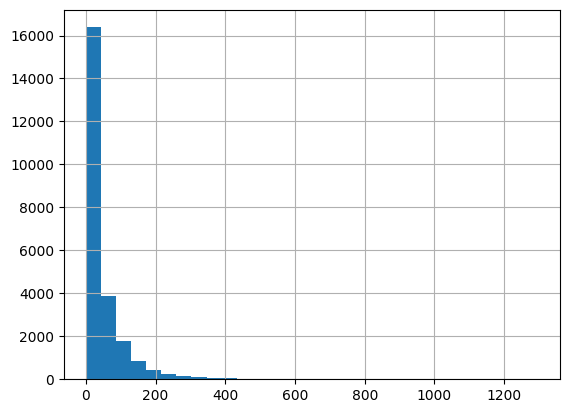

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_feat['words']]

pd.Series(seq_len).hist(bins=30)

In [ ]:
# quick test to see what our padding should be lest we end up padding to 4000+ words
(np.array(seq_len) < 200).sum() / len(seq_len)


0.9632059800664452

In [ ]:
# given ~96% of all utterances are less than 200 words, set max here
max_length = 200

In [ ]:
df_utt[['case_id', 'utt_id']].groupby('case_id').count()

,utt_id
case_id,
1955_10,593
1955_102,270
1955_110,125
1955_111,571
1955_112,46
...,...
2019_19-631,187
2019_19-635,286
2019_19-67,214


In [ ]:
# Split text from other features
train_text = train_feat['words']
val_text = val_feat['words']
test_text = test_feat['words']

In [ ]:
# Encoder for 'speaker' column
encoder_speaker = ce.OrdinalEncoder(handle_unknown='value', handle_missing='value')
train_speaker = encoder_speaker.fit_transform(train_feat['speaker'])

# Encoder for 'speaker_type' column
encoder_speaker_type = ce.OrdinalEncoder(handle_unknown='value', handle_missing='value')
train_speaker_type = encoder_speaker_type.fit_transform(train_feat['speaker_type'])

# Normalize Martin-Quinn scores
mq_scaler = MinMaxScaler()
train_mq_score = mq_scaler.fit_transform(train_feat['mq_score'].values.reshape(-1, 1))

In [ ]:
# tranform validation data
val_speaker = encoder_speaker.transform(val_feat['speaker'])
val_speaker_type = encoder_speaker_type.transform(val_feat['speaker_type'])
val_mq_score = mq_scaler.transform(val_feat['mq_score'].values.reshape(-1,1))

# transform test data
test_speaker = encoder_speaker.transform(test_feat['speaker'])
test_speaker_type = encoder_speaker_type.transform(test_feat['speaker_type'])
test_mq_score = mq_scaler.transform(test_feat['mq_score'].values.reshape(-1,1))

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    padding='max_length',
    max_length=max_length,
    truncation=True
)


In [ ]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    padding='max_length',
    max_length=max_length,
    truncation=True
)

In [ ]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    padding='max_length',
    max_length=max_length,
    truncation=True
)

In [ ]:
pd.isnull(train_mq_score).sum()

0

In [ ]:
## convert data to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_case = torch.tensor(train_feat['case_encoded'].tolist())
train_speaker = torch.tensor(train_speaker.values, dtype=torch.long)
train_speaker_type = torch.tensor(train_speaker_type.values, dtype=torch.long)
train_mq_score = torch.tensor(train_mq_score, dtype=torch.float)
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_case = torch.tensor(val_feat['case_encoded'].tolist())
val_speaker = torch.tensor(val_speaker.values, dtype=torch.long)
val_speaker_type = torch.tensor(val_speaker_type.values, dtype=torch.long)
val_mq_score = torch.tensor(val_mq_score, dtype=torch.float)
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_case = torch.tensor(test_feat['case_encoded'].tolist())
test_speaker = torch.tensor(test_speaker.values, dtype=torch.long)
test_speaker_type = torch.tensor(test_speaker_type.values, dtype=torch.long)
test_mq_score = torch.tensor(test_mq_score, dtype=torch.float)
test_y = torch.tensor(test_labels.tolist())

In [ ]:
gc.collect()
del(tokens_train)
del(tokens_val)
del(tokens_test)

In [ ]:
##### setting hyper parameters

#define a batch size
batch_size = 64

# define accumulation steps for use in gradient accumulation
accumulation_steps = 4

# define learning rate for optimizer
learning_rate = 7e-5

# define regularization for optimizer
weight_decay=1e-4

# define Dropout Rate
dropout=0.1

# define epochs
epochs = 3

In [ ]:
df_utt.speaker.unique()

array(['j__earl_warren', 'harry_f_murphy', 'j__william_o_douglas', ...,
       'adam_h_charnes', 'patrick_strawbridge', 'carey_r_dunne'],
      dtype=object)

In [ ]:
# wrap tensors
train_data = TensorDataset(train_seq,
                           train_mask,
                           train_case,
                           train_speaker,
                           train_speaker_type,
                           train_mq_score,
                           train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq,
                         val_mask,
                         val_case,
                         val_speaker,
                         val_speaker_type,
                         val_mq_score,
                         val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters

#original
#for param in bigbird.parameters():
   # param.requires_grad = False

#myswitch
for param in Legal_bert.parameters():
    param.requires_grad = False

In [ ]:
t_case_embedding = nn.Embedding(num_cases, 50)
t_speaker_embedding = nn.Embedding(num_speakers, 50)
t_speaker_type_embedding = nn.Embedding(num_speaker_types, 10)


for step, t_batch in enumerate(train_dataloader):

  # progress update after every 500 batches.
  if step == 0:
    print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

     # push the batch to gpu
    t_batch = [r for r in t_batch]

    # split batch into respective tensors. Ensure order is the same as dataset order
    t_sent_id, t_mask, t_case_ids, t_speaker, t_speaker_type, t_mq_score, t_labels = t_batch

    print("Checking max index vs number of feature")
    print(t_case_ids.max().item(), num_cases)
    print(t_speaker.max().item(), num_speakers)
    print(t_speaker_type.max().item(), num_speaker_types)
    print("Checking for negative indices")
    print((t_case_ids < 0).sum().item())
    print((t_speaker < 0).sum().item())
    print((t_speaker_type < 0).sum().item())
    print("Checking data types")
    print(t_case_ids.dtype)
    print(t_speaker.dtype)
    print(t_speaker_type.dtype)



  Batch     0  of    377.
Checking max index vs number of feature
6728 6731
146 8975
2 4
Checking for negative indices
0
0
0
Checking data types
torch.int64
torch.int64
torch.int64


In [ ]:
t_case_embeds = t_case_embedding(t_case_ids)
t_speaker_embeds = t_speaker_embedding(t_speaker)
t_speaker_type_embeds = t_speaker_type_embedding(t_speaker_type)
t_mq_score = t_mq_score

In [ ]:
t_mq_score.isnan().sum()

tensor(0)

In [ ]:
print(t_case_embeds.shape)
print(t_speaker_embeds.squeeze(1).shape)
print(t_speaker_type_embeds.squeeze(1).shape)
print(t_mq_score.shape)

torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1])


In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, Legal_bert,
                 num_cases=num_cases,
                 case_emb_dim=50,
                 num_speakers=num_speakers,
                 speaker_emb_dim=50,
                 num_speaker_types=num_speaker_types,
                 speaker_type_emb_dim=10
                 ):
        super(BERT_Arch, self).__init__()

        self.legal_bert = Legal_bert

        # Adding embedding layer for case IDs
        self.case_embedding = nn.Embedding(num_cases, case_emb_dim)

        # Adding embedding layer for speakers
        self.speaker_embedding = nn.Embedding(num_speakers, speaker_emb_dim)

        # Adding embedding layer for speaker types
        self.speaker_types_embedding = nn.Embedding(num_speaker_types, speaker_type_emb_dim)

        # dropout layer
        self.dropout = nn.Dropout(dropout)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768 + case_emb_dim + speaker_emb_dim + speaker_type_emb_dim + 1, 256) # + 1 for mq_score

        # dense layer 2
        self.fc2 = nn.Linear(256, 112)

        # dense layer 3 (Output layer)
        self.fc3 = nn.Linear(112, 1)

    # define the forward pass. Retain train data order of features
    def forward(self, sent_id, mask, case_ids, speaker, speaker_type, mq_score):

        # pass the inputs to the model
        if model_name == 'legal_bert':
            outputs = self.legal_bert(sent_id, attention_mask=mask, return_dict=True, output_hidden_states=True)
            cls_hs = outputs['hidden_states'][-1][:, 0]
        else:
            _, cls_hs = self.model(sent_id, attention_mask=mask, return_dict=False)

        # Get embeddings for case IDs
        case_embeds = self.case_embedding(case_ids)

        # Get embeddings for speakers
        speaker_embeds = self.speaker_embedding(speaker)

        # Get embeddings for speaker types
        speaker_type_embeds = self.speaker_types_embedding(speaker_type)

        # Concatenate BERT's output with case embeddings
        combined = torch.cat([cls_hs,
                              case_embeds,
                              speaker_embeds.squeeze(1),
                              speaker_type_embeds.squeeze(1),
                              mq_score], dim=1)

        # Added layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer
        x = self.fc3(x)

        return x


In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(Legal_bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = learning_rate,
                  weight_decay = weight_decay,
                  eps = 1e-8)

In [ ]:
# # compute the class weights
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)

print("Class Weights:",class_weights)

# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy = nn.BCEWithLogitsLoss()

Class Weights: [1.17969822 0.86781029]


In [ ]:
weights

tensor([1.1797, 0.8678], device='cuda:0')

In [ ]:
# Instantiate GradScaler outside the train() function
scaler = GradScaler()

# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(train_dataloader):

        # progress update after every 500 batches.
        if step % 500 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        # split batch into respective tensors. Ensure order is the same as dataset order
        sent_id, mask, case_ids, speaker, speaker_type, mq_score, labels = batch

        # Calculate the batch_weights using the labels of the current batch
        batch_labels = labels.to(device)
        batch_weights = torch.tensor([class_weights[label.item()] for label in batch_labels]).to(device)

        # clear previously calculated gradients
        model.zero_grad()

        # Use autocast for mixed-precision training
        with autocast():
            preds = model(sent_id, mask, case_ids, speaker, speaker_type, mq_score)
            loss = cross_entropy(preds, batch_labels.unsqueeze(1).float())

        # Scale the loss and perform backward pass
        loss = (loss * batch_weights).mean()
        scaler.scale(loss).backward()

        total_loss += loss.item() * batch_weights.shape[0]  # update total_loss

        # Gradient accumulation
        if (step + 1) % accumulation_steps == 0:
            # Clip gradients and update optimizer
            scaler.unscale_(optimizer)
            # Clipping gradients to 1 helps with exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            model.zero_grad()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds


In [ ]:
# function for evaluating the model
def evaluate(dataloader):

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(dataloader):

        # Progress update every XX batches.
        if step % 500 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            #Issue here so commented out
            #elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, case_ids, speaker, speaker_type, mq_score, labels = batch

        # Calculate the batch_weights using the labels of the current batch
        batch_labels = labels.to(device)
        batch_weights = torch.tensor([class_weights[label.item()] for label in batch_labels]).to(device)

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask, case_ids, speaker, speaker_type, mq_score)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, batch_labels.unsqueeze(1).float())

            # Scale the loss by the batch_weights
            loss = (loss * batch_weights).mean()

            # total_loss = total_loss + loss.item() # ORIGINAL LOSS FUNCTION
            # NEW LOSS FUNCTION BASED ON SAMPLE WEIGHTS
            total_loss += loss.item() * batch_weights.shape[0]

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# import gc
gc.collect()

0

In [ ]:
##############################
#
#    RUN THE MODEL
#
##############################

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_total_preds = train()

    #evaluate model
    valid_loss, eval_total_preds = evaluate(val_dataloader)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3

Evaluating...


RuntimeError: ignored

In [ ]:
# #load weights of best model
path = 'saved_weights.pt'
# # Move the model to CPU?
# model = model.to(device)

# # Load weights and make predictions
model.load_state_dict(torch.load(path, map_location=torch.device(device)))


#load weights of best model
# path = 'saved_weights.pt'
# model.load_state_dict(torch.load(path))

In [ ]:
# #### Breaking up test data into batches
torch.cuda.empty_cache()

# Create a DataLoader for test data
test_data = TensorDataset(test_seq,
                          test_mask,
                          test_case,
                          test_speaker,
                          test_speaker_type,
                          test_mq_score)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Initialize an empty list to hold the model predictions
preds = []

# Loop over batches
for batch in test_dataloader:
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_case_ids, b_speaker, b_speaker_type, b_mq_score = batch

    # Move input and label tensors to the GPU if available
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)

    # Make sure to turn off gradients for your model before performing inference
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, b_input_mask, b_case_ids, b_speaker, b_speaker_type, b_mq_score)

    # Move logits and labels to CPU
    logits = outputs.detach().cpu().numpy()
    preds.append(logits)

# Combine the results across the batches
preds = np.concatenate(preds, axis=0)

In [ ]:
# torch.cuda.empty_cache()
# # get predictions for test data
# with torch.no_grad():
#     preds = model(test_seq.to(device), test_mask.to(device))
#     preds = preds.detach().cpu().numpy()

# Move to CPU
# get predictions for test data
# with torch.no_grad():
#     preds = model(test_seq.to('cpu'), test_mask.to('cpu'))
#     preds = preds.detach().cpu().numpy()

In [ ]:
preds

In [ ]:
# model's performance
probs = torch.sigmoid(torch.tensor(preds)).numpy()

# Choose a threshold
threshold = 0.5

# Threshold the probabilities to get binary predictions
final_preds = (probs.squeeze() > threshold).astype(int)

# Classification Report
print(classification_report(test_y, final_preds))

In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1 score.
f1_bert = f1_score(y_true = test_y,
              y_pred = final_preds)
f1_bert

In [ ]:
final_preds.min()

In [ ]:
del(model)
torch.cuda.empty_cache()

In [ ]:
gc.collect()



---


**Below we test an XGBoost method on categorical and numerical features. This may be used to compare to combined feature analysis**







---

In [ ]:
df_utt.shape, df_test.shape

In [ ]:
df_utt.head()

In [ ]:
# Add the judges as a single category to each utterance
# This will effectively create a token for each unique court makeup
# We ideally want to know which judges are on the court, more than just the unique court

# import ast


# df_convo['judges'] = df_convo.votes_side.dropna().apply(lambda x: list(ast.literal_eval(x).keys()))
# df_utt['judges'] = df_utt.merge(df_convo, on='case_id', how='left')['judges']

In [ ]:
df_test = df_utt.copy()
# when judges are added
# df_test.judges = df_test.judges.astype('str')
df_test.head()

In [ ]:
# Split with groups based on cases to ensure each sampled utterance+prediction comes from the same transcript
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=123)

groups = df_test['case_id']
X = df_test.drop(columns=['case_id', 'win_side', 'reply_to', 'words','convo_id','utt_id','docket_id'])
y = df_test['win_side']

# Get the indices for training and intermediary sets
train_idx, temp_idx = next(gss.split(X, y, groups))

# create train and intermediary sets
train_cats, temp_cats, train_labels, temp_labels = X.iloc[train_idx], X.iloc[temp_idx], y.iloc[train_idx], y.iloc[temp_idx]

# Also subset groups data for correct indexing
groups_train, groups_temp = groups.iloc[train_idx], groups.iloc[temp_idx]

# second split from intermediary for test and validation
gss_val = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=123)

# Get the indices from intermediary for test and validation sets
test_idx, val_idx = next(gss.split(temp_cats, temp_labels, groups_temp))

# create test and validation sets
val_cats, test_cats, val_labels, test_labels = temp_cats.iloc[test_idx], \
                                              temp_cats.iloc[val_idx], \
                                              temp_labels.iloc[test_idx], \
                                              temp_labels.iloc[val_idx]

In [ ]:
train_cats.head()


In [ ]:
# First, change the type of the specified columns to "category". This will
# assign a "code" to each unique category value.
test_cats = test_cats.copy()
train_cats = train_cats.copy()

test_cats.loc[:, "speaker"] = test_cats["speaker"].astype('category')
train_cats["speaker"] = train_cats["speaker"].astype('category')
test_cats["speaker_type"] = test_cats["speaker_type"].astype('category')
train_cats["speaker_type"] = train_cats["speaker_type"].astype('category')
test_cats["term"] = test_cats["term"].astype('category')
train_cats["term"] = train_cats["term"].astype('category')
# test_cats["judges"] = test_cats["judges"].astype('category')
# train_cats["judges"] = train_cats["judges"].astype('category')

# Second, replace the strings with their code values.
test_cats["speaker"] = test_cats["speaker"].cat.codes
train_cats["speaker"] = train_cats["speaker"].cat.codes
test_cats["speaker_type"] = test_cats["speaker_type"].cat.codes
train_cats["speaker_type"] = train_cats["speaker_type"].cat.codes
test_cats["term"] = test_cats["term"].cat.codes
train_cats["term"] = train_cats["term"].cat.codes
# test_cats["judges"] = test_cats["judges"].cat.codes
# train_cats["judges"] = train_cats["judges"].cat.codes

# Third, cast numerical features as floats to indicate to XGBoost which are numerical
# test_cats["meta.side"] = test_cats["meta.side"].astype('float')
# train_cats["meta.side"] = train_cats["meta.side"].astype('float')
test_cats["mq_score"] = test_cats["mq_score"].astype('float')
train_cats["mq_score"] = train_cats["mq_score"].astype('float')


In [ ]:
train_cats.head()


In [ ]:
# import packages
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
# Define the parameter grid
# param_grid = {
#     'gamma': [0.0, 0.1, 0.5, 1, 1.5, 2],
#     'reg_alpha': [0.0, 0.1, 0.25, 0.5, 1],
#     'reg_lambda': [0.0, 0.1, 0.25, 0.5, 1],
# }

# # Make an appropriate scorer function using make_scorer
# f1_scorer = make_scorer(f1_score)

# # Create an instance of the XGBClassifier
# model = XGBClassifier(tree_method='gpu_hist')

# # Create the grid search object
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=f1_scorer, cv=5, verbose=2)

# # Fit the grid search object to the data
# grid_search.fit(train_cats, train_labels)

# # Print the best parameters
# print("Best parameters: ", grid_search.best_params_)

# # Use the best estimator to predict labels for the test set
# best_model = grid_search.best_estimator_
# predictions = best_model.predict(test_cats)

# # Calculate the F1 score
# f1 = f1_score(y_true=test_labels, y_pred=predictions)


In [ ]:
# The above block yields the following results for XGBClassifier Regularization given
# categories "speaker", "speaker_type", "side", "term", "mq_score"

gamma = 1.5
reg_alpha = 0.1
reg_lambda = 0.0



In [ ]:
# Create an instance of the classifier
model = XGBClassifier(gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda, tree_method='gpu_hist')

# Train it on the training set.
model.fit(train_cats, train_labels)

# Use the trained model to predict the labels for the test set.
predictions = model.predict(test_cats)

# Calculate the F1 score.
f1 = f1_score(y_true = test_labels,
              y_pred = predictions)
f1

In [ ]:
# plot feature importance
plot_importance(model)

pyplot.show()

In [ ]:
feat_gains = model.get_booster().get_score(importance_type="gain")

pyplot.bar(feat_gains.keys(), feat_gains.values(), label=list(feat_gains.values()))
pyplot.xticks(rotation = 30)

In [ ]:
feat_gains

In [ ]:
print(classification_report(test_labels, predictions))
